# Business Analytics Final Project
### BusinessAnalyticsSpring2021

"Predictive modelling the incremental impact of a treatment(discount) on an individual's behaviour."


Author:Yuanhong Sun

In [2]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import math
import os
import datetime as dt
import missingno as msno

In [3]:
df_data = pd.read_csv('data.csv')
df_model = df_data.copy()
df_model.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


recency: months since last purchase

history: $value of the historical purchases

used_discount: indicates if the customer used a discount before

used_bogo: indicates if the customer used a buy one get one before

zip_code: class of the zip code as Suburban/Urban/Rural

is_referral:indicates if the customer was acquired from referral channel

channel: customer using, Phone/Web/Multichannel

offer: the offers sent to the customers, Discount/But One Get One/No Offer

conversion: customer conversion(buy or not)

##### Checking and working with missing value with missingno

<AxesSubplot:>

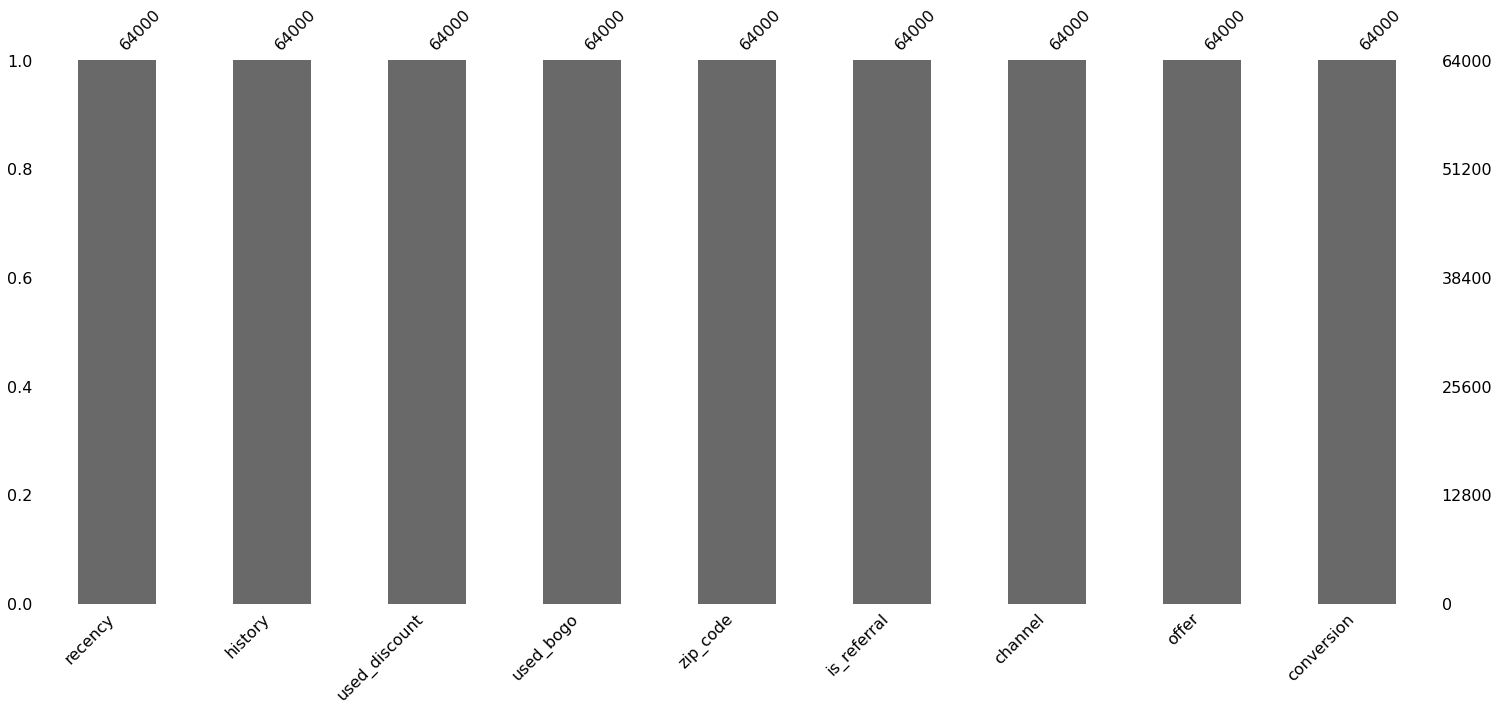

In [4]:
msno.bar(df_model)

Here, we see that in each column we need to have 64000 data and each column has 64000 data!

## Data Preprocessing

In [5]:
df_model = df_model.rename(columns={'conversion': 'target'})
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})
df_model = pd.get_dummies(df_model)

In [6]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,-1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,-1,0,0,0,1,0,0,1


In [10]:
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True)
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True)

##### Target Class Declaration
Control Non-Responders(CN)

Customers that don't make a purchase without an offer (value = 0)

Control Responders(CR)

Customers that make a purchase without an offer (value = 1)

Treatment Non-Responders(TN)

Customer that don't make a purchase and receive an offer (value = 2)

Treatment Responders(TR)

Customers that make a purchase and receive an offer (value = 3)

In [12]:
def declare_tc(df:pd.DataFrame):
    #CN
    df['target_class'] = 0 
    #CR
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df

In [13]:
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

## Uplift Modeling

In [14]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

The Uplift model uses Lai’s Generalized Weighed Uplift (LGWUM) to calculate the uplift score, which incorporates weighted estimators to enhance the accuracy of the uplift predictions.


LGWUM is one of several strategies that was introduced in 2002 by Lo. Where P Denotes a Probabilty Score, T denotes the total treated population (TR + TN), and C denotes the total untreated population (CR + CN). Thus, Uplift Score can be calculated as:

Uplift Score = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

### Train Test Sets Split 

In [15]:
def uplift_split(df_model:pd.DataFrame):
    
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.3,random_state=886,stratify=df_model['treatment'])
    
    # stratify ensure that the class distribution in the target variable is preserved in both the training and testing datasets.
    
    return X_train,X_test, y_train, y_test

### Model Building 

In [16]:
def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):

    result = pd.DataFrame(X_test).copy()    

    uplift_model = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
    uplift_proba = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    
    result['uplift_score'] = result.eval('proba_CN/(proba_CN+proba_CR)+ proba_TR/(proba_TN+proba_TR)- proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')
    
    result['target_class'] = y_test
    
    return result


### Integrate two functions

In [17]:
def uplift(df_model:pd.DataFrame):
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

From above function, we can directly get the result of uplift model, the score.

**Positive Uplift Score: A positive uplift score indicates that an individual is more likely to respond positively to the treatment compared to not receiving the treatment. These individuals are referred to as treatment responders or persuadables. They are the target group for whom the treatment is expected to have a positive impact.

**Negative or Zero Uplift Score: A negative or zero uplift score suggests that an individual is not likely to respond positively to the treatment. These individuals are referred to as treatment non-responders or non-persuadables. The treatment is not expected to have a significant impact on their behavior or outcomes.



In [18]:
bogo_uplift = uplift(df_model_bogo)
discount_uplift = uplift(df_model_discount)

In [27]:
bogo_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
23226,3,194.21,0,1,0,-1,0,1,0,0,1,0,0.439855,0.065344,0.384316,0.110485,0.187897,3
19380,7,29.99,1,0,0,0,0,0,1,0,1,0,0.472718,0.051020,0.417545,0.058716,0.051740,0
32992,5,415.49,0,1,0,0,0,1,0,0,1,0,0.392334,0.068620,0.441604,0.097442,0.063805,1
16481,10,29.99,0,1,1,0,0,0,1,0,0,1,0.445033,0.029730,0.465528,0.059709,0.102119,0
2739,3,220.14,1,0,0,0,0,1,0,0,1,0,0.392887,0.046654,0.480469,0.079989,0.073156,0


In [28]:
discount_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
42205,1,709.89,1,0,1,0,1,0,0,0,1,0,0.494465,0.031905,0.227262,0.246367,0.919109,0
16131,2,931.93,0,1,1,1,0,0,1,0,0,1,0.396458,0.029443,0.485884,0.088215,0.169053,2
5319,10,187.33,0,1,0,1,0,0,1,0,1,0,0.478247,0.053677,0.394316,0.073759,0.113337,2
13011,10,61.54,0,1,1,1,0,0,1,0,1,0,0.501208,0.005138,0.459274,0.034379,0.118990,2
28946,2,56.11,0,1,1,0,1,0,0,0,1,0,0.497806,0.090270,0.322145,0.089780,0.128902,0


### Rank the data by the uplift score 

In [21]:
def qini_rank(uplift:pd.DataFrame):
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

### Evaluate the uplift value with the QINI criterion 

The QINI coefficient assesses the effectiveness of a model or treatment strategy in identifying individuals who are most likely to respond positively to a treatment.

A higher QINI coefficient indicates a more effective uplift model, as it signifies a larger uplift gain achieved compared to random selection. 

A positive value suggests that the uplift model performs better than random selection, while a negative value indicates poor model performance.

QINI coefficient is the area between the uplift gain curve and the diagonal line representing random selection.

In [29]:
def qini_eval(ranked:pd.DataFrame):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    
    return merged

### Plot the QINI

In [30]:
def qini_plot(merged:pd.DataFrame):
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    sns.set_style('whitegrid')
    
    handles, labels = ax.get_legend_handles_labels()
    
    plt.xlabel('Cumulative % of Total Population',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    
    return ax

### Combine all functions 

In [31]:
def qini(uplift:pd.DataFrame):
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

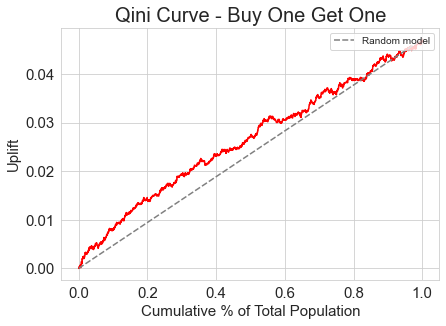

In [32]:
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

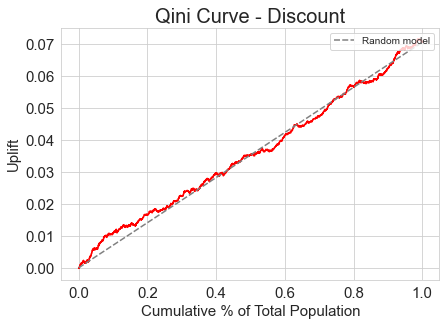

In [33]:
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)

From the plot we can see that bogo strategt is more effective than a discount given greater area between a random selection (diagonal line) and the strategy (red line).

Each point on the QINI curve provides insight into the performance of the uplift model at a particular segment of the population. The uplift gain at that segment indicates the relative effectiveness of the model in identifying individuals who are most likely to respond positively to the treatment.